# Basic Synthetic Data Generation with DeepBridge

This tutorial demonstrates how to generate synthetic data using the DeepBridge library. I'll walk you through creating synthetic datasets with different methods and comparing their results.

## Overview

In this demonstration, we'll:
1. Create a sample dataset with mixed data types
2. Generate synthetic versions using three different methods:
   - Gaussian Copula
   - CTGAN (Conditional Tabular GAN)
   - UltraLight Generator
3. Evaluate and compare the quality of each method
4. Visualize the differences between original and synthetic data

## Understanding the Different Methods

Each synthetic data generation method has its unique characteristics:

### Gaussian Copula
- Statistical method that preserves the marginal distributions and correlations between features
- Good balance between quality and computational efficiency
- Works well for numerical data with linear relationships
- Medium memory requirements

### CTGAN (Conditional Tabular GAN)
- Neural network-based approach using Generative Adversarial Networks
- Can capture complex, non-linear relationships in the data
- Highest quality for capturing complex patterns
- More computationally intensive and requires more memory
- Longer training time

### UltraLight Generator
- Simplest and fastest approach with minimal memory requirements
- Uses basic statistical modeling rather than complex ML models
- Excellent for large datasets or limited computational resources
- Quality may be lower for complex relationships

## Example Implementation

Let's look at the code to implement these methods:

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import sys
import os

sys.path.append(os.path.expanduser("~/projetos/DeepBridge"))


from deepbridge.core.db_data import DBDataset
from deepbridge.synthetic import Synthesize

from deepbridge.validation.wrappers import (
    FeaturePerturbationTests,
    OutlierRobustnessTests,
    DistributionShiftTests,
    RobustnessSuite
)
#---------------------------------------------------------
# Preparação de dados com cuidado especial 
#---------------------------------------------------------
print("Carregando e preparando dados...")

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Gerar dados sintéticos com duas classes
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(20)])
y = pd.Series(y)

# Verificar e lidar com valores ausentes
print(f"Valores NaN em X antes da limpeza: {X.isna().sum().sum()}")
print(f"Valores infinitos em X: {np.isinf(X.values).sum()}")

# Resetar índices para garantir alinhamento limpo
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Exportar como .parquet
X_train.to_parquet("X_train.parquet")
X_test.to_parquet("X_test.parquet")
y_train.to_frame(name="target").to_parquet("y_train.parquet")
y_test.to_frame(name="target").to_parquet("y_test.parquet")

# Resetar índices novamente após a divisão
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



# Criar DataFrames de treino e teste com nomes explícitos de colunas
train_df = X_train.copy()
train_df['target'] = y_train
test_df = X_test.copy()
test_df['target'] = y_test

# Verificação final
print(f"NaN em train_df: {train_df.isna().sum().sum()}")
print(f"NaN em test_df: {test_df.isna().sum().sum()}")

# Treinar modelo
print("\nTreinando modelo...")
model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(X_train, y_train)

import joblib
joblib.dump(model, "modelo.pkl")

# # Criar objeto de dataset
# print("\nCriando objeto de dataset...")
# dataset = DBDataset(
#     train_data=train_df,
#     test_data=test_df,
#     target_column='target',
#     model=model
# )



Carregando e preparando dados...
Valores NaN em X antes da limpeza: 0
Valores infinitos em X: 0
NaN em train_df: 0
NaN em test_df: 0

Treinando modelo...


['modelo.pkl']

In [2]:
dataset._original_data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,1.665142,-0.287854,1.195177,0.392456,0.268851,0.936993,-0.480214,-0.432660,1.322703,0.727168,...,-0.045044,-1.209435,-0.926163,-0.299303,1.242827,-0.267766,0.065892,-0.443368,-0.162062,1
1,-0.316073,1.924410,-0.103222,0.926215,-0.582759,-2.967793,0.265362,1.422748,1.203884,0.197316,...,-0.134279,1.236131,0.965397,-1.525438,0.088658,0.615771,-0.617652,1.884777,0.390465,0
2,-0.184087,0.210315,0.078007,0.142378,-0.345104,0.355069,-1.307777,1.388665,1.665603,0.574042,...,-1.835769,1.365526,0.381353,-0.893538,-0.630143,-0.772192,-0.109864,-0.016471,1.282795,1
3,-0.838176,0.113192,0.741320,-0.451641,1.209010,0.432423,0.535459,2.505449,0.593539,-0.305632,...,1.064171,-0.263161,1.895149,-0.739069,-1.372410,-0.600339,1.048204,-0.087880,-0.987523,1
4,-0.087148,-0.335940,0.190211,0.723070,0.115240,-1.382500,-0.243406,0.701256,-1.363868,1.268808,...,0.646083,0.318827,-0.153809,2.299509,-1.085174,1.140896,-2.782960,0.293270,0.014382,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.108445,0.350605,0.976507,1.120686,-0.204932,-1.119419,-2.072135,0.385213,0.394881,0.001804,...,-0.701957,0.205486,-0.133279,0.341192,0.114309,0.295195,-1.089343,0.532871,0.157347,1
996,-0.909683,1.789049,0.681360,1.228981,-0.307808,-2.772994,0.408607,0.534817,-0.667780,-0.584618,...,-0.886681,0.458387,-0.637308,-1.403214,-2.087027,-0.936506,-0.031059,1.756773,-1.102292,0
997,-0.749172,0.044467,-1.502871,-0.611634,-0.661541,0.521719,-0.745942,-0.856349,0.210496,-0.110005,...,-0.614539,0.013043,1.118632,-0.666738,-0.179251,1.315508,1.292060,-0.149724,-1.239562,0
998,-0.081456,-0.013940,-0.042332,-0.046497,-1.451835,-1.640245,0.906834,1.365560,0.577517,1.677240,...,-0.121075,-0.589579,0.450055,1.788760,0.486842,0.675491,0.995527,0.530438,0.483841,0


In [3]:
import warnings
import matplotlib as plt

# Filtrar os avisos relacionados a feature names
warnings.filterwarnings("ignore", category=UserWarning, 
                       message="X does not have valid feature names")

# # Criar suite de robustez e configurar
# print("\nExecutando testes de robustez...")
# suite = RobustnessSuite(dataset, verbose=True)

# # Método 1: Configurar e executar
# results_quick = suite.config('quick').run()
# print(f"Pontuação de robustez (quick): {results_quick['robustness_scores']['overall_score']:.3f}")

# # Método 2: Configurar para teste completo
# results_full = suite.config('full').run()
# print(f"Pontuação de robustez (full): {results_full['robustness_scores']['overall_score']:.3f}")

# # Usuários avançados ainda podem personalizar completamente os testes
# custom_config = {
#     'feature_perturbation': [
#         {'type': 'noise', 'params': {'feature_name': 'mean radius', 'level': 0.3}}
#     ],
#     'outlier_robustness': [
#         {'type': 'isolation_forest', 'params': {'contamination': 0.15}}
#     ]
# }

# # Executar com configuração personalizada
# results_custom = suite.run_custom_test(custom_config)


Initializing feature perturbation tests...
Detected binary classification problem with 2 unique values: [0 1]
Initialized FeaturePerturbationTests with classification problem type
Dataset has 20 features
Baseline performance: {'accuracy': 0.8566666666666667, 'f1': 0.8566491479534958}
Baseline performance: {'accuracy': 0.8566666666666667, 'f1': 0.8566491479534958}
Initializing outlier robustness tests...
Detected binary classification problem with 2 unique values: [0 1]
Initialized OutlierRobustnessTests with classification problem type
Dataset has 20 features
Baseline performance: {'accuracy': 0.8566666666666667, 'f1': 0.8566491479534958}
Baseline performance: {'accuracy': 0.8566666666666667, 'f1': 0.8566491479534958}
Initializing distribution shift tests...
Detected binary classification problem with 2 unique values: [0 1]
Initialized DistributionShiftTests with classification problem type
Dataset has 20 features
Baseline performance: {'accuracy': 0.8566666666666667, 'f1': 0.856649147

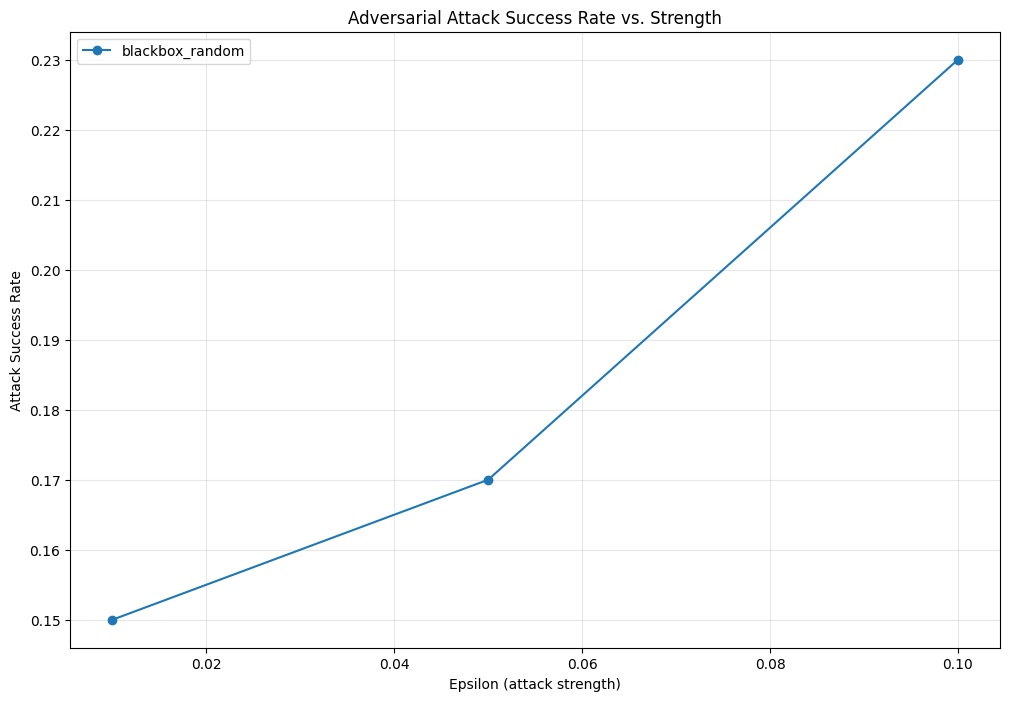

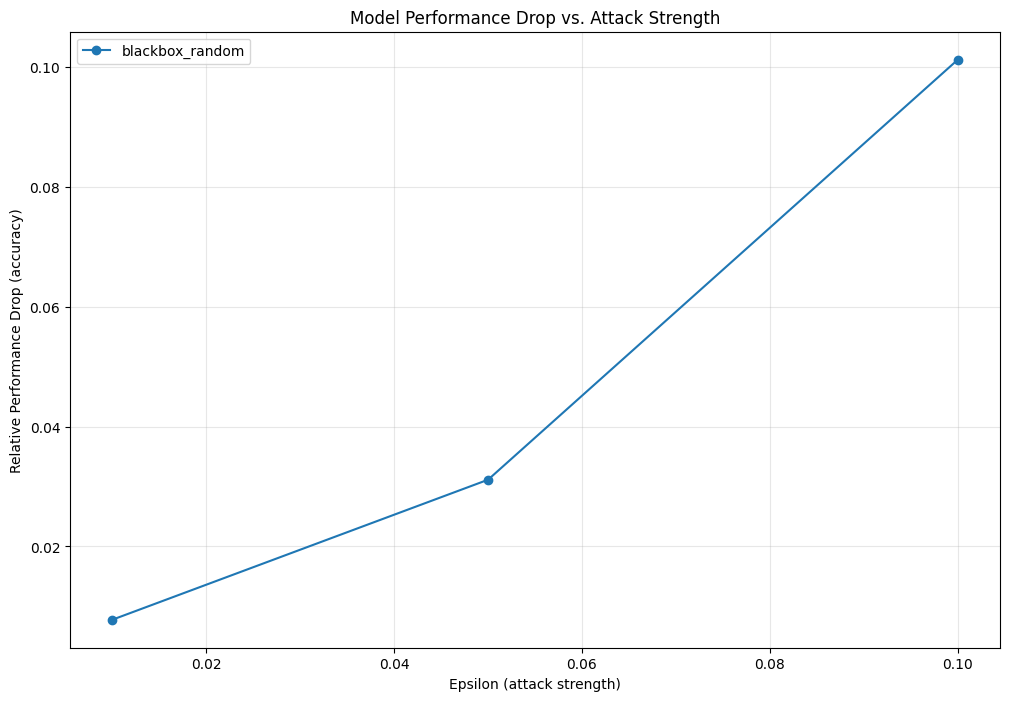

In [4]:
suite = RobustnessSuite(dataset, verbose=True)
results_full = suite.config('full').run()


suite.save_report("report_full.html")

In [5]:
import json
print(json.dumps(results_full['results'] if 'results' in results_full else results_full, indent=2)[:1000])

TypeError: Object of type int64 is not JSON serializable

In [ ]:
import os
suite.save_report("report1.html")

In [ ]:
suite.config('quick')

In [ ]:
# Acessar resultados organizados
robustness_results = results_full['results']

# Acessar visualizações
visualizations = robustness_results['visualizations']

In [ ]:
visualizations

In [ ]:
# Verifique primeiro se a visualização existe
if 'feature_importance' in visualizations:
    with open('feature_importance.html', 'w') as f:
        f.write(visualizations['feature_importance'])
else:
    print("Visualização 'feature_importance' não disponível.")

    
# Exemplo: Exibir uma visualização específica em um notebook
from IPython.display import HTML
HTML(visualizations['robustness_summary'])

# Exemplo: Salvar uma visualização em um arquivo HTML
with open('feature_importance.html', 'w') as f:
    f.write(visualizations['feature_importance'])

In [ ]:
synthetic_df = Synthesize(
    dataset=dataset,
    method='gaussian',
    num_samples=1000,  
    verbose=False
)

In [ ]:
from deepbridge.synthetic.metrics.similarity import calculate_similarity

# Acesse os dados originais e os dados sintéticos
original_data = synthetic_df.original_data
synthetic_data = synthetic_df.data

# Calcule a similaridade
similarity_scores = calculate_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    # Parâmetros opcionais:
    metric='euclidean',         # Métrica de distância a ser usada
    n_neighbors=5,              # Número de vizinhos a considerar
    sample_size=10000,          # Tamanho máximo da amostra a usar
    random_state=42,            # Seed para reprodutibilidade
    verbose=True                # Mostrar informações de progresso
)

# similarity_scores é um pandas.Series com um score para cada amostra sintética
# Valores mais próximos de 1 indicam maior similaridade (mais parecidos)
# Valores mais próximos de 0 indicam menor similaridade (mais diferentes)

# Estatísticas de similaridade
print(f"Similaridade média: {similarity_scores.mean():.4f}")
print(f"Similaridade mínima: {similarity_scores.min():.4f}")
print(f"Similaridade máxima: {similarity_scores.max():.4f}")

# Você também pode visualizar a distribuição dos scores
import matplotlib.pyplot as plt
plt.hist(similarity_scores, bins=50)
plt.title('Distribuição dos Scores de Similaridade')
plt.xlabel('Score de Similaridade')
plt.ylabel('Frequência')
plt.show()

In [ ]:
from deepbridge.synthetic.metrics.similarity import filter_by_similarity

# Filtra dados com similaridade acima de um limiar
filtered_data = filter_by_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    threshold=0.9,              # Remove samples com similaridade >= 0.9
    verbose=True
)

print(f"Amostras originais: {len(synthetic_data)}")
print(f"Amostras após filtragem: {len(filtered_data)}")

In [ ]:
# Avaliação da diversidade dos dados sintéticos
from deepbridge.synthetic.metrics.similarity import calculate_diversity

diversity_metrics = calculate_diversity(
    synthetic_data=synthetic_df.data,
    verbose=True
)

# Avaliação das diferenças de correlação entre variáveis numéricas
from deepbridge.synthetic.metrics.similarity import evaluate_pairwise_correlations

correlation_analysis = evaluate_pairwise_correlations(
    original_data=original_data,
    synthetic_data=synthetic_data
)

# Mostrar pares de colunas com maiores diferenças de correlação
print(correlation_analysis.head(10))

In [ ]:
try:
    from deepbridge.synthetic.metrics.similarity import plot_distribution_comparison
    
    fig = plot_distribution_comparison(
        original_data=original_data,
        synthetic_data=synthetic_data
    )
    plt.show()
except ImportError:
    print("Módulo de visualização não disponível")

In [ ]:
# Gerando um relatório HTML
report_path = synthetic_df.save_report("relatorio_dados_sinteticos.html")
print(f"Relatório gerado e salvo em: {report_path}")

In [ ]:
X = synthetic_df.data.drop('target', axis=1)
y = synthetic_df.data['target']

In [ ]:
y_pred = model.predict(X)

In [ ]:
# # 6. Avaliação do modelo
# accuracy = accuracy_score(y, y_pred)
# report = classification_report(y, y_pred)

# print(report)

In [ ]:
# Importações adicionais para a nova estrutura refatorada
from deepbridge.validation.model_types.classification.robustness import ClassificationRobustness


# Usando o objeto dataset e modelo que você já criou
robustness_tester = ClassificationRobustness(dataset=dataset, model=model)

# Opção 1: Teste específico de robustez (por exemplo, ruído gaussiano)
gaussian_results = robustness_tester.evaluate_gaussian_noise_robustness(
    noise_levels=[0.01, 0.05, 0.1, 0.2],
    metrics=['accuracy', 'f1', 'auc'],
    n_iterations=5,
    test_set=True  # Usar conjunto de teste
)

In [ ]:
from deepbridge.validation import Validator

# Usar o Validator integrado
robustness_validator = Validator(dataset, "robustness")
results = robustness_validator.evaluate_model_robustness(
    perturb_method='raw',
    perturb_sizes=[0.01, 0.05, 0.1, 0.2]
)

# Visualizar resultados
robustness_validator.visualize_results(result_type='robustness')

# Ou gerar um relatório
report = robustness_validator.generate_validation_report(output_format='markdown')
print(report)

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gerando dados sintéticos
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testando diferentes valores de regularização (C)
c_values = np.logspace(-2, 2, 10)  # Valores de C de 0.01 a 100
accuracies = []
coef_variances = []

for C in c_values:
    model = LogisticRegression(C=C, solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    
    # Avaliação da acurácia
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Variância dos coeficientes do modelo (indicador de estabilidade)
    coef_variances.append(np.var(model.coef_))

# Criando o gráfico interativo
fig = go.Figure()

# Linha da Acurácia
fig.add_trace(go.Scatter(
    x=c_values, y=accuracies, mode='lines+markers',
    name="Acurácia", line=dict(color='blue'), yaxis="y1"
))

# Linha da Variância dos Coeficientes
fig.add_trace(go.Scatter(
    x=c_values, y=coef_variances, mode='lines+markers',
    name="Variância dos Coeficientes", line=dict(color='red'), yaxis="y2"
))

# Configurações do layout
fig.update_layout(
    title="Teste de Robustez: Impacto da Regularização",
    xaxis=dict(title="C (Parâmetro de Regularização)", type="log"),
    yaxis=dict(title="Acurácia", side="left"),
    yaxis2=dict(title="Variância dos Coeficientes", side="right", overlaying="y"),
    legend=dict(x=0.1, y=1.1),
)

# Exibir o gráfico
fig.show()


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Criando um gráfico simples para demonstração
fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 1, 6], mode='lines+markers', name='Exemplo'))

# Salvar como um arquivo HTML
pio.write_html(fig, "grafico.html")

print("Arquivo 'grafico.html' salvo! Agora você pode abri-lo no navegador.")


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Criando um gráfico simples
fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 1, 6], mode='lines+markers', name='Exemplo'))

# Gerando código HTML do gráfico SEM a barra de ferramentas
html_code = pio.to_html(fig, full_html=False, config={'displayModeBar': False})

# Salvando como um arquivo HTML com o gráfico embutido
with open("pagina_com_grafico.html", "w", encoding="utf-8") as f:
    f.write(f"""
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <h1>Meu Gráfico Interativo</h1>
        {html_code}
    </body>
    </html>
    """)

print("Arquivo 'pagina_com_grafico.html' criado! Abra no navegador para visualizar.")

